In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
import warnings
import os
import sys
import datetime as dt
import cartopy.crs as ccrs
#from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
#warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy12MHW/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
region='NAtl'

In [3]:
nl = dict(zip( ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2', 'CanESM5', 'GEM5.2-NEMO', 'GEM5-NEMO', 'CanCM4i-IC3',],
               [       11,                 11,         11,           11,              8,            9,        11,            11,          11,            11,])) 
modict={'Jacox':['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 
                        'NASA-GEOSS2S', 'NCEP-CFSv2'],
        'CanSIPSv2':['CanCM4i','GEM-NEMO'],
        'CanSIPSv21':['CanCM4i-IC3','GEM5-NEMO'],
        'CanSIPSv3':['CanESM5','GEM5.2-NEMO'],
        'GFDLNASA':[ 'GFDL-SPEAR','NASA-GEOSS2S'],}
lonW=-110+360
lonE=0+360
latS=20
latN=80
pextent=[-75, -23, 39, 65]
proj=ccrs.Orthographic(central_longitude=-50, central_latitude=44.7, globe=None)

In [4]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
clim_years = [1991, 2020]
years=clim_years
mhwdir = basepath+'/mhw/detrended';
#f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{clim_years[0]}_{clim_years[-1]}.nc'
fobs=xr.open_dataset(f_obs).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
mods=modict['CanSIPSv3']
il=3 # 3 months lead time
flist=[]
for modi in mods:
    if il<nl[modi]:
        # Load MHWs
        f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{clim_years[0]}_{clim_years[1]}.nc'
        flist.append(f_in)
ffor=xr.open_mfdataset(flist,chunks={'time':1,'X':-1,'Y':-1,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                   coords='minimal',parallel=True,
                       preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"])).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
M=40
mhwfor=ffor.is_mhw.data[:(-1*il),...].sum(axis=1)/M if il>0 else ffor.is_mhw.data.sum(axis=1)/M
mhwobs=fobs.is_mhw.data[il:,...]
lm=np.sum(fobs.is_mhw.data,axis=0)==0
area=np.cos(np.pi/180*np.ones(np.shape(mhwobs[0,...]))*np.expand_dims(fobs.lat.values,axis=1))*111.3**2

In [5]:
# ice mask
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
#with xr.open_dataset(f_ice) as fice:
fice=xr.open_dataset(f_ice).sel(X=slice(lonW,lonE),Y=slice(latS,latN))
icemask1=np.nanmax(fice.ice.data,axis=0)>0
Athresh=.50
Tthresh=.9
#Amax=np.zeros((20,)+np.shape(icemask1))
# for ind in range(0,20):
#     Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
lost=np.where(fice.ice>Athresh,1,0).sum(axis=0)
#AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)
imask=lost>(1-Tthresh)*np.shape(fice.ice)[0]

/tmp/reo000/792754/ipykernel_2240248/2453365123.py:5: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0


In [6]:
ffor.lon

<xarray.DataArray 'lon' (X: 110)> Size: 440B
dask.array<getitem, shape=(110,), dtype=float32, chunksize=(110,), chunktype=numpy.ndarray>
Coordinates:
  * X        (X) float32 440B 250.0 251.0 252.0 253.0 ... 357.0 358.0 359.0

In [7]:
lonind = lambda lon,tol=.1:int(np.argwhere((np.abs(fobs.lon.values-lon)<tol)|\
                                       (np.abs(fobs.lon.values+360-lon)<tol)|\
                                       (np.abs(fobs.lon.values-360-lon)<tol))[0][0])
latind = lambda lat,tol=.1:int(np.argwhere(np.abs(fobs.lat.values-lat)<tol)[0][0])

In [8]:
24.90+50.40+123.7-27

172.0

In [9]:
i1s=lonind(-67)
i1e=lonind(-42)+1
j1s=latind(42)
j1e=latind(50)+1

i2s=lonind(-64)
i2e=lonind(-43)+1
j2s=latind(51)
j2e=latind(65)+1

In [10]:
A1mask=~lm
A1mask[:j1s,:]=0
A1mask[j1e:,:]=0
A1mask[:,:i1s]=0
A1mask[:,i1e:]=0

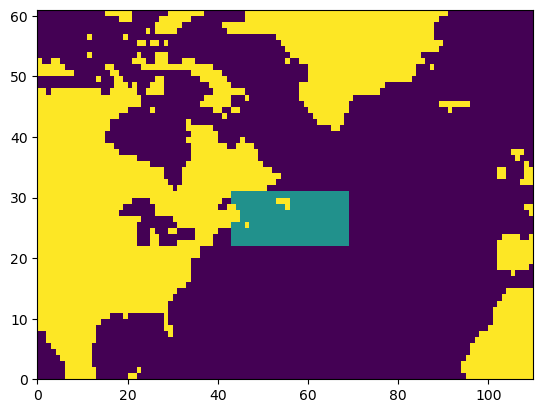

In [11]:
plt.pcolormesh(A1mask+2*lm)

In [12]:
A2mask=~lm
A2mask[:j2s,:]=0
A2mask[j2e:,:]=0
A2mask[:,:i2s]=0
A2mask[:,i2e:]=0

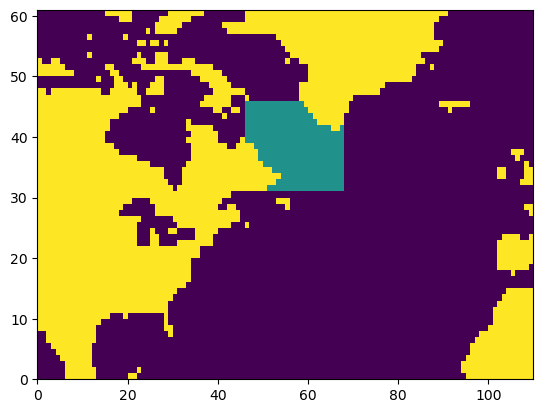

In [13]:
plt.pcolormesh(A2mask+2*lm)

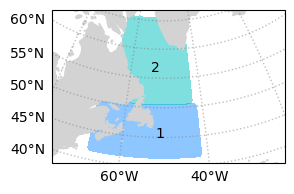

In [14]:
fig = plt.figure(figsize=[3, 3])
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(pextent, ccrs.PlateCarree())

# ax.pcolormesh(fobs.lon.values,fobs.lat.values,A1mask,vmin=.5,vmax=1.5,
#               transform=ccrs.PlateCarree(),shading='nearest')
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A1mask, [.5,1.5],colors=['dodgerblue',],linestyles='-',alpha=.5,
                 transform=ccrs.PlateCarree(),)
cs = ax.contourf(fobs.lon.values,fobs.lat.values, A2mask, [.5,1.5],colors=['c',],linestyles='-',alpha=.5,
                 transform=ccrs.PlateCarree(),)
ax.text(-54,56,'2',transform=ccrs.PlateCarree())
ax.text(-52,45,'1',transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
#gl.xlocator = mticker.FixedLocator([-90, -70, -50,-30,-10,10])
#gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60,70])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels=False
gl.right_labels=False
# if iax==ax1:
#     gl.top_labels = False
#     gl.right_labels = False
# elif iax==ax2:
#     gl.top_labels = False
#     gl.left_labels = False

In [15]:
Area1=np.nansum(A1mask*area)
Area2=np.nansum(A2mask*area)

In [16]:
dfAlist=[pd.read_csv(f'figs/dfA_{region}_y{yy}.csv',index_col=0) for yy in range(years[0],years[-1]+1)]
dfA=pd.concat(dfAlist,ignore_index=True)
dfA

,year,month,A1_obs,A2_obs,A1_lag0_weighted,A2_lag0_weighted,A1_lag0_gt1,A2_lag0_gt1,A1_lag0_gt5,A2_lag0_gt5,...,A1_lag8_gt21,A2_lag8_gt21,A1_lag8_gt25,A2_lag8_gt25,A1_lag8_gt29,A2_lag8_gt29,A1_lag8_gt33,A2_lag8_gt33,A1_lag8_gt37,A2_lag8_gt37
0,1991,1,78410.546614,44816.943837,12683.243231,108818.219461,1.228891e+05,3.410185e+05,3.472926e+04,243307.569084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991,2,147220.940195,56675.010229,100545.508063,188686.556628,4.141206e+05,4.177771e+05,2.544152e+05,316124.411394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1991,3,247677.950144,123639.098826,101074.025980,220259.598318,4.299284e+05,5.097388e+05,3.172775e+05,355819.007821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1991,4,52793.001166,113815.165697,101001.435034,145667.295602,6.394871e+05,3.057632e+05,3.592049e+05,249700.468844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1991,5,27325.413595,225869.158550,95508.598805,34037.038837,7.674257e+05,4.965107e+05,2.898958e+05,59534.360266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2020,8,134407.910657,681493.544192,338152.384071,200347.362122,1.764401e+06,1.233586e+06,1.105706e+06,638221.346347,...,33793.537060,21841.686521,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
356,2020,9,125432.725693,12861.887516,250187.198882,149320.413661,1.238217e+06,1.046778e+06,7.148612e+05,509151.888034,...,43756.848241,6380.132010,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
357,2020,10,457689.226755,73319.362523,674055.163775,35029.517929,1.389531e+06,3.672426e+05,1.085290e+06,88239.383775,...,96560.142461,125549.087768,9205.847723,68902.120423,0.0,6927.108338,0.0,0.0,0.0,0.0
358,2020,11,179036.259628,46838.096406,362493.178034,3937.715836,8.776636e+05,4.293551e+04,6.705041e+05,7795.825915,...,76030.311465,99804.405928,0.000000,42444.940680,0.0,0.000000,0.0,0.0,0.0,0.0


In [17]:
cmap = mpl.colormaps['jet']
colors = cmap(np.linspace(0, 1, 40))
styles=['-','--','-.',':']
dates=np.array([dt.datetime(yy,mm,15) for ind,(yy,mm) in dfA[['year','month']].iterrows()])

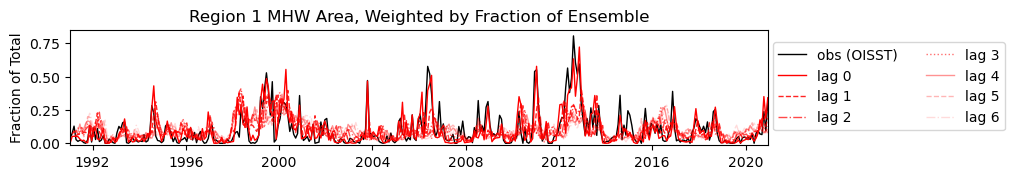

In [28]:
fig,ax=plt.subplots(1,1,figsize=(9,1.5))
ax.plot(dates,dfA.A1_obs/Area1,'k-',label='obs (OISST)',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A1_lag{il}_weighted']/Area1,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'lag {il}',lw=1)#marker='.',
ax.set_title('Region 1 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
ax.legend(loc=1,bbox_to_anchor=[1.35,.95],ncols=2)
ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region1_weighted.png',bbox_inches='tight',transparent=True)

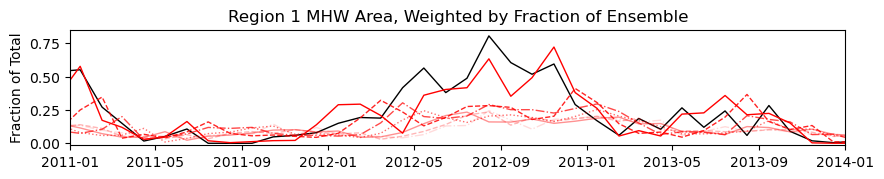

In [19]:
fig,ax=plt.subplots(1,1,figsize=(10,1.5))
ax.plot(dates,dfA.A1_obs/Area1,'k-',label='obs',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A1_lag{il}_weighted']/Area1,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}',lw=1)#
ax.set_title('Region 1 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
#ax.legend(loc=1,bbox_to_anchor=[1.3,1.1])
ax.set_xlim([dt.datetime(2011,1,1),dt.datetime(2014,1,1)])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region1_weightedZoom.png',bbox_inches='tight')

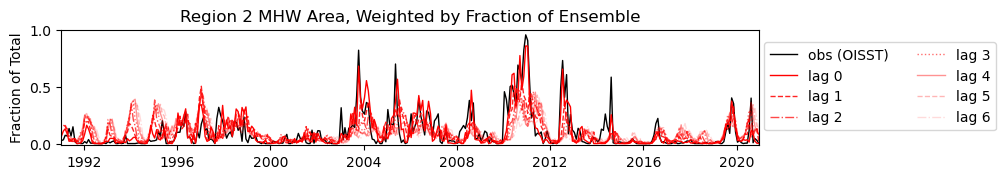

In [29]:
fig,ax=plt.subplots(1,1,figsize=(9,1.5))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs (OISST)',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'lag {il}',lw=1)#marker='.',
ax.set_title('Region 2 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
ax.legend(loc=1,bbox_to_anchor=[1.35,.95],ncols=2)
ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([-.015,1])
fig.savefig('figs/MHWAreaFrac_{region}Region2_weighted.png',bbox_inches='tight',transparent=True)

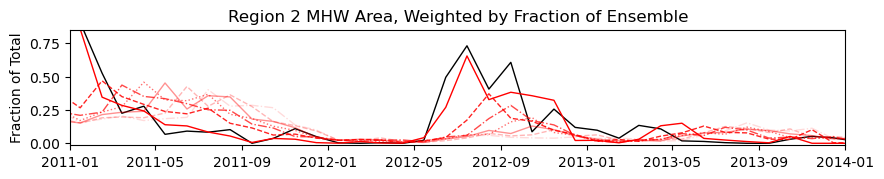

In [21]:
fig,ax=plt.subplots(1,1,figsize=(10,1.5))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}',lw=1)#
ax.set_title('Region 2 MHW Area, Weighted by Fraction of Ensemble')
ax.set_ylabel('Fraction of Total')
#ax.legend(loc=1,bbox_to_anchor=[1.3,1.1])
ax.set_xlim([dt.datetime(2011,1,1),dt.datetime(2014,1,1)])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region2_weightedZoom.png',bbox_inches='tight')

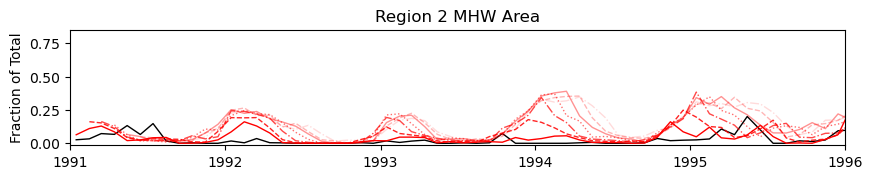

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,1.5))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs',lw=1)
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}',lw=1)#
ax.set_title('Region 2 MHW Area')
ax.set_ylabel('Fraction of Total')
#ax.legend(loc=1,bbox_to_anchor=[1.3,1.1])
ax.set_xlim([dt.datetime(1991,1,1),dt.datetime(1996,1,1)])
ax.set_ylim([-.015,.85])
fig.savefig('figs/MHWAreaFrac_{region}Region2_weightedZoom1992.png',bbox_inches='tight')

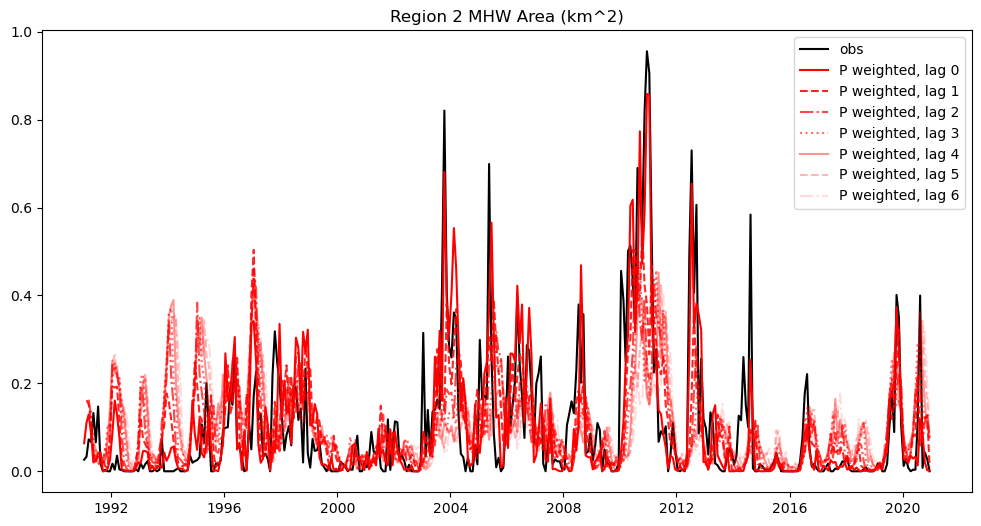

In [23]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
ax.plot(dates,dfA.A2_obs/Area2,'k-',label='obs')
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted']/Area2,'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}')
ax.set_title('Region 2 MHW Area (km^2)')
ax.legend()
fig.savefig('figs/MHWArea_{region}Region2_weighted.png',bbox_inches='tight')

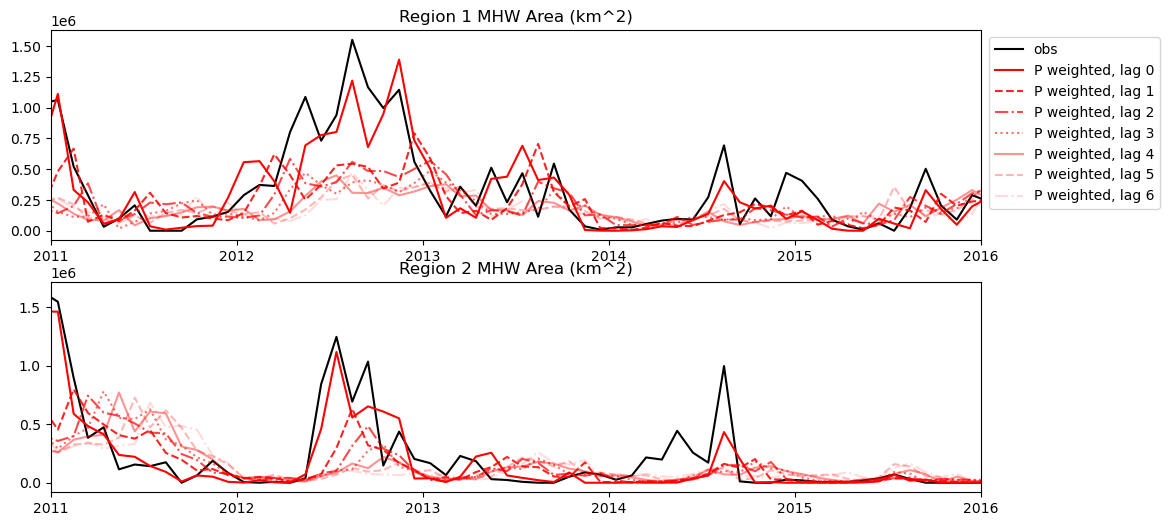

In [24]:
fig,axs=plt.subplots(2,1,figsize=(12,6))
ax=axs[0]
ax.plot(dates,dfA.A1_obs,'k-',label='obs')
for il in range(0,7):
    ax.plot(dates,dfA[f'A1_lag{il}_weighted'],'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}')
ax.set_title('Region 1 MHW Area (km^2)')
ax.legend(loc=1,bbox_to_anchor=[1.2,1])
ax=axs[1]
ax.plot(dates,dfA.A2_obs,'k-',label='obs')
for il in range(0,7):
    ax.plot(dates,dfA[f'A2_lag{il}_weighted'],'r',linestyle=styles[il%len(styles)],alpha=1-il/7,label=f'P weighted, lag {il}')
ax.set_title('Region 2 MHW Area (km^2)')
#ax.legend()
for iax in axs:
    iax.set_xlim((dt.datetime(2011,1,1),dt.datetime(2016,1,1)))
fig.savefig('figs/MHWArea_{region}Region1and2_weighted.png',bbox_inches='tight')

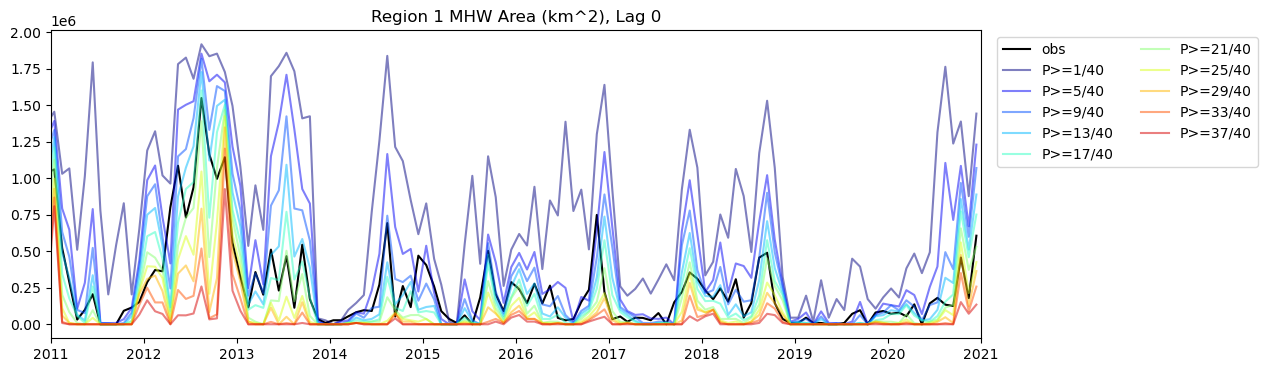

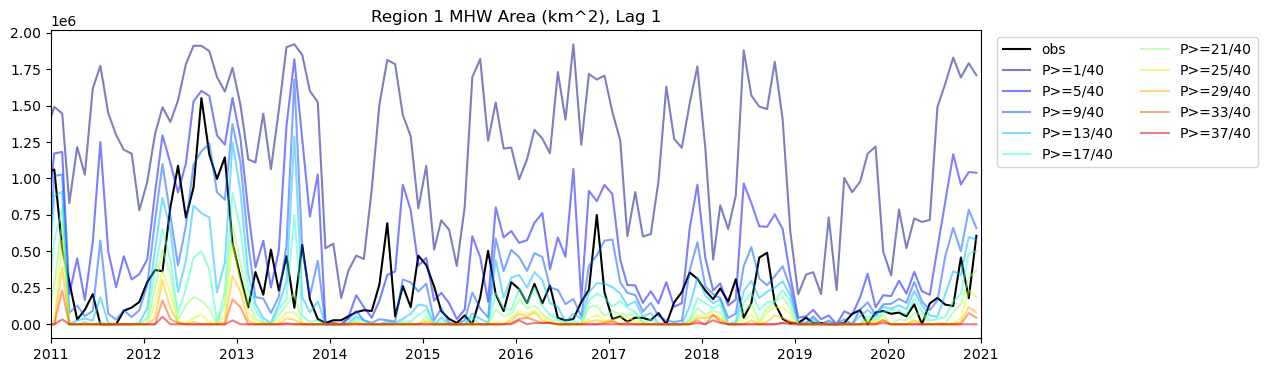

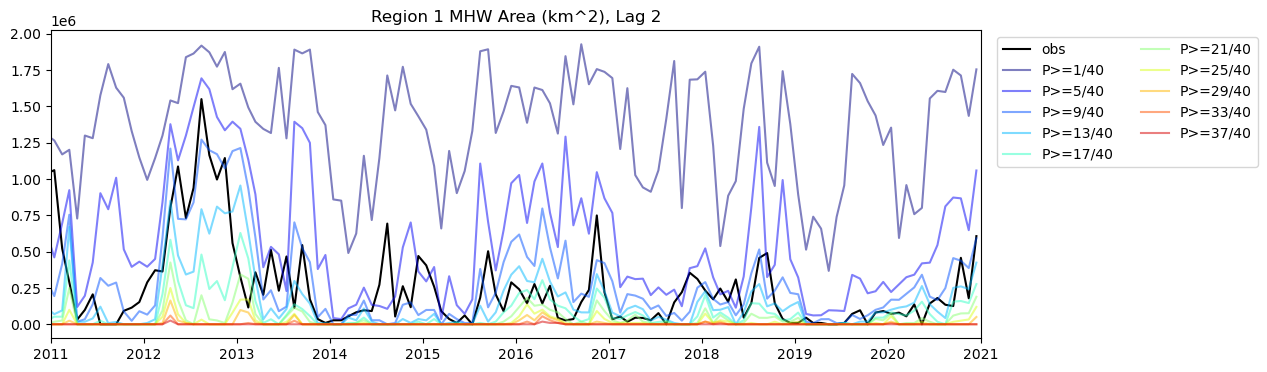

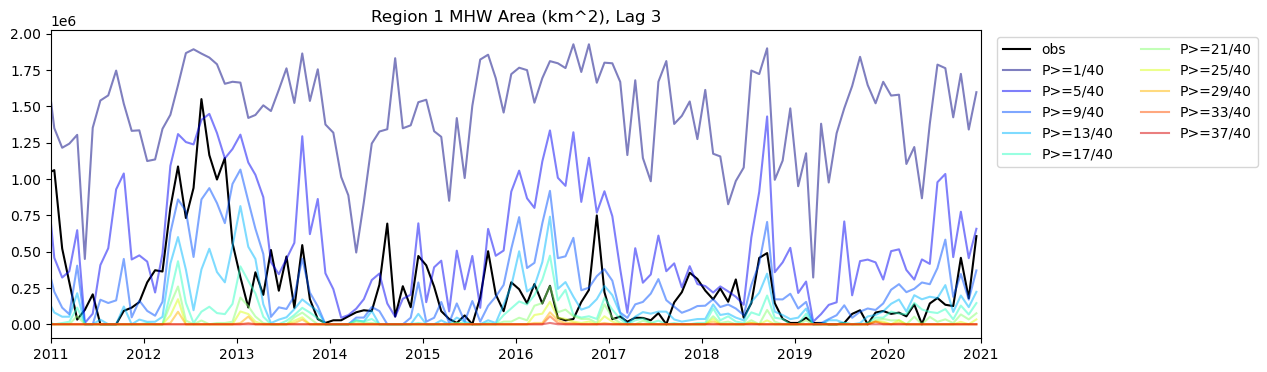

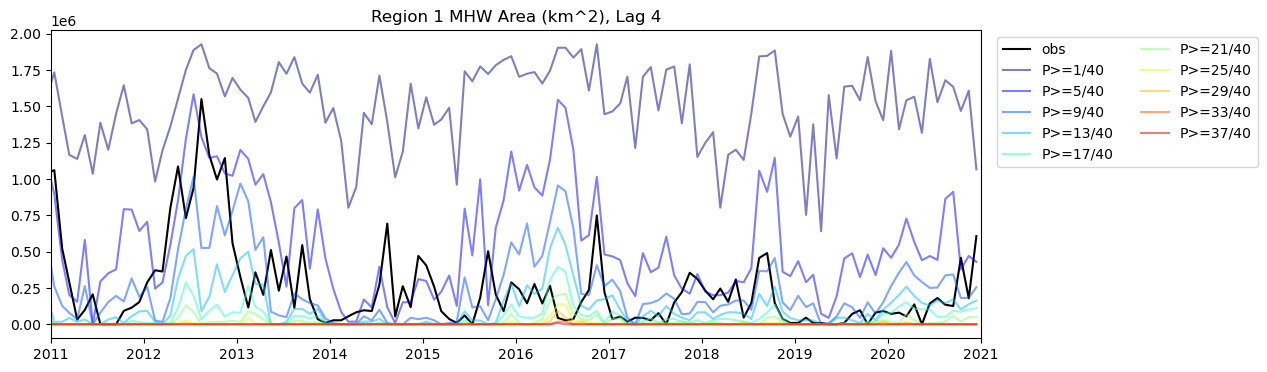

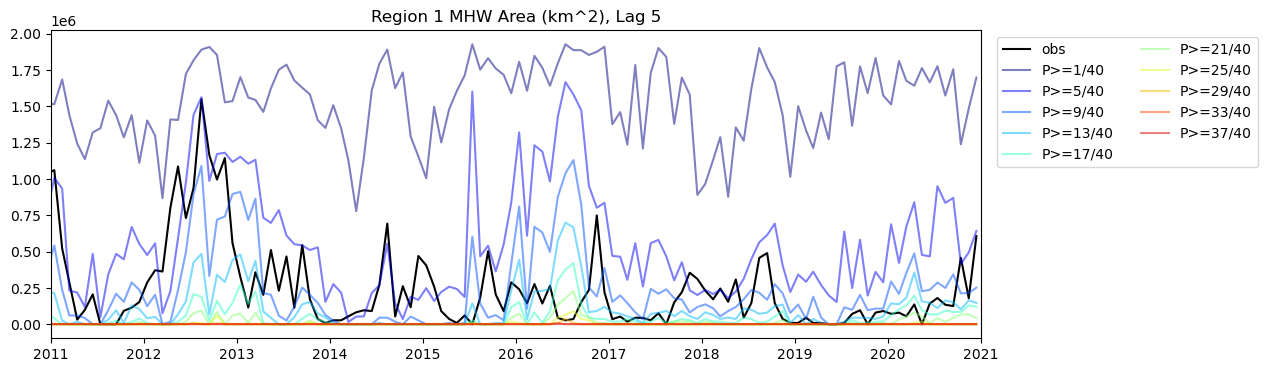

In [25]:
for lag in range(0,6):
    fig,ax=plt.subplots(1,1,figsize=(12,4))
    ax.plot(dates,dfA.A1_obs,'k-',label='obs')
    for ii in range(1,41,4):
        ax.plot(dates,dfA[f'A1_lag{lag}_gt{ii}'],color=colors[ii-1],alpha=.5,label=f'P>={ii}/40')
    ax.set_title(f'Region 1 MHW Area (km^2), Lag {lag}')
    ax.legend(ncols=2,bbox_to_anchor=[1.01,1])
    ax.set_xlim((dt.datetime(2011,1,1),dt.datetime(2021,1,1)))
    fig.savefig(f'figs/MHWAreaByPThresh_{region}Region1_lag{lag}.png',bbox_inches='tight')